- 机器学习项目主要步骤：
1. 放眼大局
2. 获取数据
3. 探索和可视化数据以获取见解
4. 为机器学习算法准备数据
5. 选择一个模型并训练它
6. 微调模型
7. 展示解决方案
8. 发布，监控和维护系统

## 放眼大局
利用加州的一份住房与人口统计数据来构建房价预测模型。数据中汇总了各个最小统计单元的指标，如人口数量、家庭收入中位数、房价中位数等。这里我们把这些最小统计单元统称为“地区” （一个地区通常有600-3000人）。你的模型需要基于这些特征学习，在给定其他指标的情况下预测任一地区的房价中位数。

拿出你的机器学习项目清单， 对于多数机器学习项目，它可以工作得很好；但确保根据需求进行调整。

### 框定问题

你问老板的第一个问题应该是业务目标到底是什么。建立模型可能不是最终目标。公司期望如何使用该模型并从中受益？了解目标很重要，因为它将决定你如何框定问题、你将选择哪些算法、你将使用哪种性能指标来评估你的模型，以及你将花费多少精力来调整它。

老板回答说，你的模型的输出（对一个地区房价中位数的预测）将连同许多其他信息一起输入到另一个机器学习系统（见下图）。这个下游系统将决定在给定的区域是否值得投资。做到这一点至关重要，因为它直接影响收入。

![机器学习流水线](./images/end_to_end_ml_proj/p1.png)

- 流水线：

系列数据处理组件称为数据流水线。流水线在机器学习系统中非常常见，因为有大量数据需要操作并且需要应用很多的数据转换。

组件通常是异步运行的。每个组件都会拉取大量数据，对其进行处理，然后将结果输出到另一个数据存储器中。然后，一段时间后，流水线中的下一个组件拉取此数据并给出自己的输出。每个组件都是相当独立的：组件之间的接口就是数据存储。这使得系统易于掌握（借助于数据流图），不同的团队可以专注于不同的组件。此外，如果一个组件发生故障，下游组件通常可以仅使用损坏组件的最后输出继续正常运行（至少一段时间）。这使得架构非常健壮。

另外，如果没有实施适当的监控，损坏的组件可能会在一段时间内被忽视。数据变得陈旧，整个系统的性能会下降。


- 在开始训练机器学习系统之前，请你先思考并尝试回答以下问题：

<details>
<summary> 你认为这是什么类型的机器学习任务？</summary>

**这是一个监督学习任务**。
因为我们拥有带有标签的数据：每条记录都包括模型的输入（如人口、收入中位数等）和目标输出（该地区的房价中位数）。模型可以利用这些已标注的样本进行训练。

</details>

<details>
<summary> 它是分类任务还是回归任务？</summary>

**这是一个回归任务**，因为我们希望预测的是一个连续数值（即房价中位数），而不是分类标签。

进一步来说，这是一个 **单预测值回归** 问题：我们只预测一个输出值。
不过，它也是一个 **多元回归**（multiple regression）问题，因为我们使用多个输入特征来预测这个输出值。

</details>

<details>
<summary>应该使用批量学习还是在线学习？</summary>

**推荐使用批量学习（Batch Learning）**。

原因如下：
- 数据集大小适中，足以完全载入内存。
- 没有实时数据流不断涌入系统。
- 环境相对稳定，不需要模型频繁调整以应对数据分布漂移。

因此，传统的批量学习方法即可胜任，不需要在线学习技术。

如果数据量很大，可以将批量学习的工作拆分到多个服务器，或者使用在线学习技术
</details>


### 选择性能指标

下一步是选择性能指标。回归问题的典型性能度量是均方根误差(Root Mean Square Error，RMSE)。它给出了系统在其预测中通常会产生多大误差，并为较大的误差赋予较高的权重

- RMSE 公式及符号说明

我们使用下列公式来计算预测结果的均方根误差（Root Mean Square Error, RMSE）：

$$
\text{RMSE}(X, h) = \sqrt{ \frac{1}{m} \sum_{i=1}^{m} \left(h\left(x^{(i)}\right) - y^{(i)} \right)^2 }
$$



- 符号说明

这个公式引入了几个在机器学习中非常常见的符号，以下是各个符号的含义：

- **m** 是你测量 RMSE 的数据集中的**实例数**。
  例如，如果你在 2000 个地区的验证集上评估 RMSE，则有：
  `m = 2000`

- **x⁽ⁱ⁾** 是数据集中第 *i* 个实例的所有**特征值**（不包括标签）的向量，
  **y⁽ⁱ⁾** 是它的**标签**（该实例的期望输出值）。

  例如，如果数据集中的第一个地区位于经度 -118.29°，纬度 33.91°，居住有 1416 人，收入中位数为 38372 美元，房屋价值中位数为 156400 美元（暂时忽略其他特征），那么：

  $$
  x^{(1)} = \begin{bmatrix}
  -118.29 \\
  33.91 \\
  1416 \\
  38372
  \end{bmatrix}
  \quad \text{和} \quad
  y^{(1)} = 156400
  $$

- **X** 是一个矩阵，包含数据集中所有实例的所有特征值（不包括标签）。
  每个实例为一行，第 *i* 行等于 \(x^{(i)}\) 的转置，记作 $$(x^{(i)})^T$$

表示特征矩阵 **X**：

$$
X =
\begin{pmatrix}
(x^{(1)})^\mathrm{T} \\
(x^{(2)})^\mathrm{T} \\
\vdots \\
(x^{(1999)})^\mathrm{T} \\
(x^{(2000)})^\mathrm{T}
\end{pmatrix}
=
\begin{pmatrix}
-118.29 & 33.91 & 1416 & 38372 \\
\vdots & \vdots & \vdots & \vdots
\end{pmatrix}
$$

- **h** 是系统的**预测函数**，也称为假设。
  当给系统一个实例的特征向量 $ x^{(i)} $ 时，它会输出该实例的预测值：

  $$
  \hat{y}^{(i)} = h(x^{(i)})
  $$

---

- 平均绝对误差（MAE）

$$
\text{MAE}(X, h) = \frac{1}{m} \sum_{i=1}^{m} \left| h(x^{(i)}) - y^{(i)} \right|
$$

RMSE 和 MAE 都是衡量两个向量（预测向量和目标向量）之间距离的方法。各种距离度量或范数是可能的：

- 计算平方和的根（RMSE）对应于欧几里得范数：这是我们都熟悉的距离概念。
  它也被称为 $\ell_2$ 范数，记为 $\| \cdot \|_2$（或简写为 $\| \cdot \|$）。

- 计算绝对值之和（MAE）对应于 $\ell_1$ 范数，记为 $\| \cdot \|_1$。
  这有时被称为曼哈顿范数，因为如果你只能沿着正交的城市街区行动，那么它会测量城市中两点之间的距离。

- 一般而言，包含 $n$ 个元素的向量 $v$ 的 $\ell_k$ 范数定义为：

$$
\|v\|_k = (|v_1|^k + |v_2|^k + \cdots + |v_n|^k)^{1/k}
$$

- $\ell_0$ 给出向量中的非零元素的数量，$\ell_\infty$ 给出向量中的最大绝对值。


范数指数越高，它就越关注**大值**而忽略小值。这就是 RMSE 比 MAE 对异常值更敏感的原因。

但是当异常值呈指数级减少时（例如在钟形曲线中），RMSE 表现非常好，并且通常是首选。



### 检查假设

最后，**列出并验证已有假设**是非常重要的一步，有助于及早发现潜在问题。
例如，你假设系统输出的房价将被下游系统原样使用。但如果下游其实将其转化为“便宜”“中等”“昂贵”等类别并用于分类模型，那你当前的回归建模将毫无意义。

因此，**在明确需求之前，不应盲目假设问题类型**。幸运的是，在与下游团队沟通后，你确认他们确实需要实际价格值。


## 获取数据


In [180]:
import sys

assert sys.version_info >= (3, 7)   # 检查python版本

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")  # 检查sklearn版本

In [181]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

调用load_housing_data()时，它会查找datasets/housing.tgz文件。如果找不到，它会在当前目录中创建datasets目录，从ageron/data GitHub存储库下载housing.tgz文件，并将其内容提取到datasets目录中。这将创建datasets/housing目录，其中包含housing.csv文件。最后，该函数将此CSV文件加载到包含所有数据的Pandas DataFrame对象中，并返回它。

In [182]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [183]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [184]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [185]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


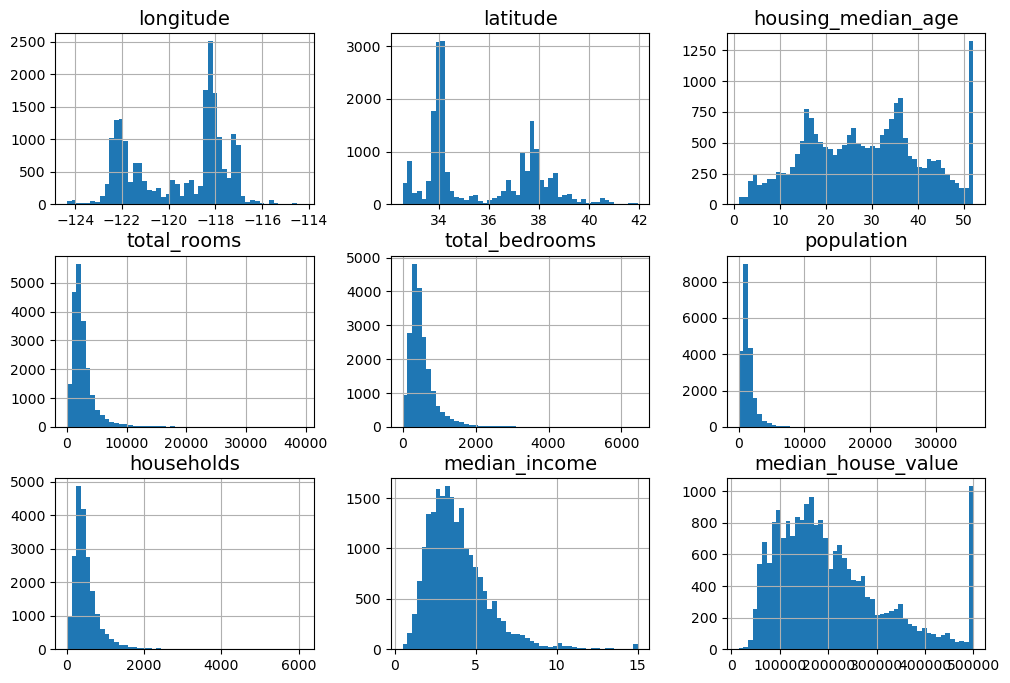

In [186]:
import matplotlib.pyplot as plt

# 定义默认字体大小
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
plt.show()

### 创建测试集

In [187]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [188]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [189]:
len(test_set)

4128

上述实现的弊端：数据更新后，或者反复多次运行分离训练和测试数据后，还是会看到整个数据集

解决方案：通过标识符来决定它是否应该进入测试集（假设实例的标识符是唯一且不变的）。比如，可以计算每个实例标识符的哈希值，如果哈希值低于或等于最大哈希值的20%，则将该实例放入测试集中。这可以确保测试集在多次运行中保持一致，即使刷新数据集也是如此。

In [190]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * (2**32)

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [191]:
housing_with_id = housing.reset_index()  # 加一个索引列
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [192]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]  # 通过经纬度创建id
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Scikit-Learn提供了一些函数以各种方式将数据集拆分为多个子集。最简单的函数是train_test_split()，它所做的事情与我们之前定义的shuffle_and_split_data()函数几乎相同，

但有几个附加功能。首先，有一个random_state参数允许你设置随机生成器种子，保证在数据不变的前提下，训练和测试的拆分是一致的。

其次，你可以将多个具有相同行数的数据集传递给它，并且它会在相同的索引上拆分它们（这非常有用，例如，如果你有一个单独标签的DataFrame）

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

- 分层采样：
数据集足够大，纯随机采样没问题。但如果不够大，会引入显著采样偏差。

向1000个人做问卷调查，尝试保证1000个人足够代表全体人口。例如人口中女性占51.1%， 男性占48.9%，因此对1000个人问卷调查尝试保证这样一个比例：511名女性和489名男性，这个就是分层采样。

定义：将总体分为称做层的同质子组，并从每个层中抽取正确数量的实例以保证测试集能代表总体。

如果进行调查的人使用纯随机采样，则大约有10.7%的机会会抽取到女性参与者少于48.5%或超过53.5%的偏差测试集，可以因为采样偏差，得到错误的结论

In [16]:
# 利用二项分布 N次独立随机实验，每次结果为1的概率为p，x次为1的概率 （x<=N)

from scipy.stats import binom
sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.10736798530929942


In [17]:
# 纯数值模拟采样偏差的概率
samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis=1)
((samples < 485) | (samples > 535)).mean()

0.1082

In [18]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

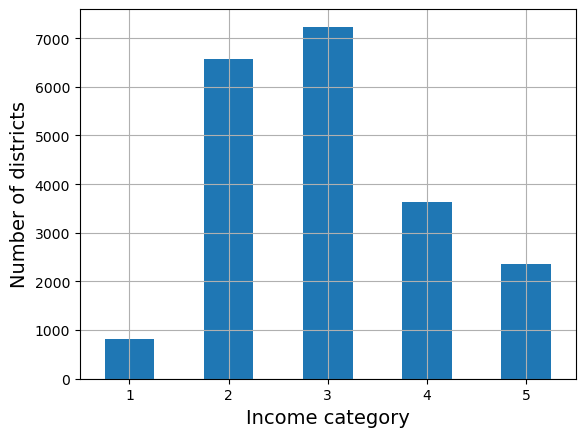

In [19]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [21]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)  # 分层采样 单词拆分

In [22]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [23]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [24]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [25]:
housing = strat_train_set.copy()

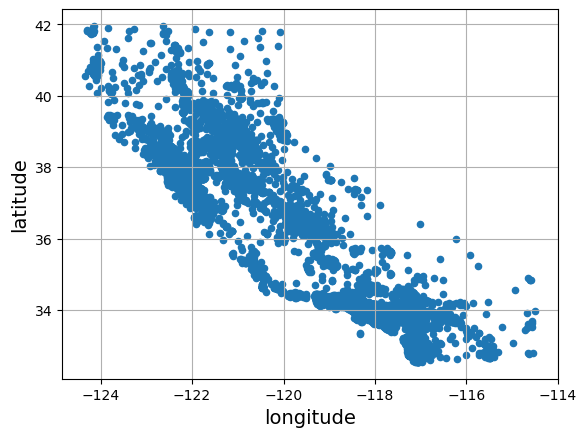

In [26]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

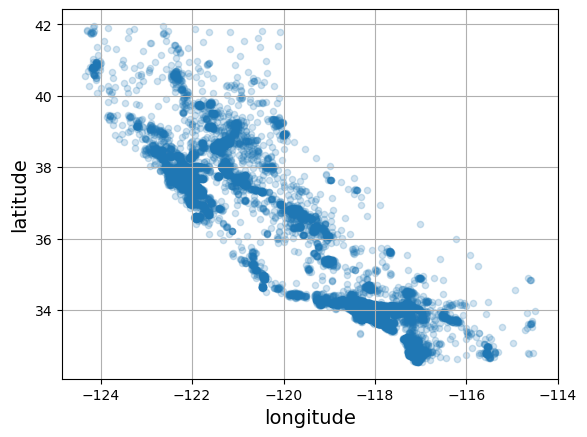

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

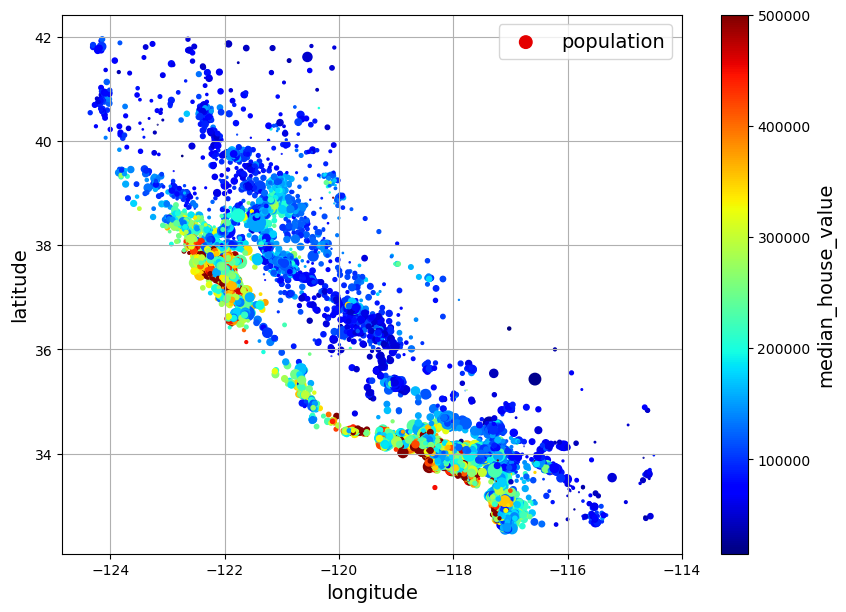

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

In [29]:
corr_matrix = housing.corr(numeric_only=True)

In [30]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

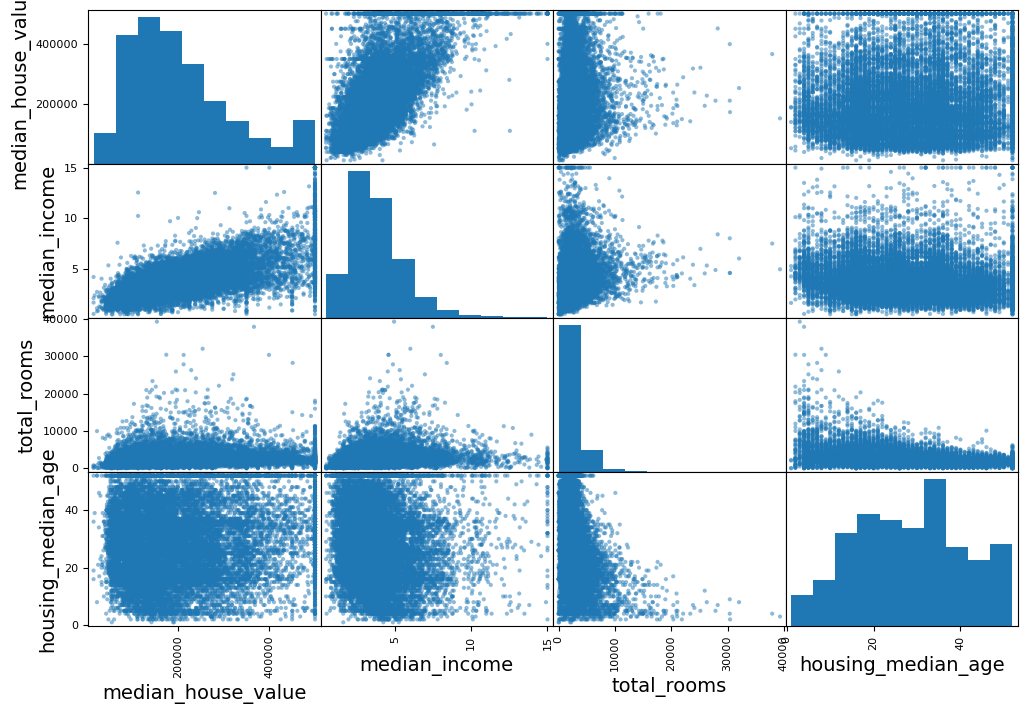

In [31]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

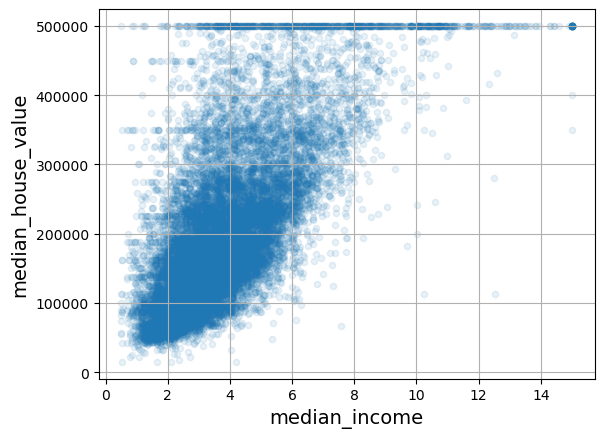

In [32]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

In [33]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [195]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

为机器学习算法准备数据。这里应该为这个目的编写函数，而不是手动执行此操作
原因如下：
1. 可以在任何数据集上轻松地重现这些转换（例如，下次你获得新的数据集时)。
2. 可以逐步构建一个可在未来项目中重复使用的转换函数库。
3. 可以在实时系统中使用这些函数来转换新数据，再将其提供给你的算法

In [196]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [197]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [198]:
housing_option1 = housing.copy()

housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # 去掉相应的地区

housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [199]:
housing_option2 = housing.copy()

housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # 去掉整个属性

housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [200]:

housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  # 将缺失值填为某个值 （零，均值，中位数等）归责

housing_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


使用一个方便的Scikit-Learn类：SimpleImputer，而不是前面的代码。它的好处是将存储每个特征的中位数值：这不仅可以在训练集上估算缺失值，而且可以在验证集、测试集和任何提供给模型的新数据上估算缺失值。要使用它，首先需要创建一个SimpleImputer实例，指定要用该属性的中位数替换每个属性的缺失值：

In [201]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [41]:
housing_num = housing.select_dtypes(include=[np.number])  # 只能根据数值属性计算中位数，创建仅包含数值属性的数据副本，排除文本属性
print(type(housing_num))

<class 'pandas.core.frame.DataFrame'>


In [42]:
imputer.fit(housing_num)  # 使用fit()方法将imputer实例拟合到训练数据中：

SimpleImputer(strategy='median')

In [43]:
imputer.statistics_  # imputer简单地计算了每个属性的中位数并将结果存储在它的statistics_实例变量中
housing_num.median().values
X = imputer.transform(housing_num)
X



array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

缺失值也可以替换为平均值(strategy="mean")，或替换为最频繁的值(strategy="most_frequent")，或替换为常数值(strategy="constant"，fill_value=...)。最后两种策略支持非数值数据。

Scikit-Learn的设计Scikit-Learn的API设计得非常好，以下是一些设计原则：
- 一致性： 所有对象共享一个一致且简单的接口。
- 估计器：任何可以根据数据集估计某些参数的对象都称为估计器（例如，SimpleImputer是估计器）。估计本身由fit()方法执行，它将一个数据集作为参数（或两个数据集用于监督学习算法，第二个数据集包含标签）。指导估计过程所需的任何其他参数都被视为超参数（例如SimpleImputer的strategy），并且必须将其设置为实例变量（通常通过构造函数参数）。
- 转换器：一些估计器（例如SimpleImputer）也可以转换数据集，这些被称为转换器。同样，方法名很简单：转换由transform()方法执行，将要转换的数据集作为参数。它返回转换后的数据集。这种转换通常依赖于学习到的参数，就像SimpleImputer的情况一样。所有的转换器还有一个名为fit_transform()的便捷方法，相当于先调用fit()再调用transform()（但有时fit_transform()会经过优化，运行速度更快）。
- 预测器：一些估计器在给定数据集的情况下能够进行预测，这些被称为预测器。例如，LinearRegression模型是一个预测器，给定一个国家的人均GDP，预测生活满意度。预测器有一个predict()方法，它获取新实例的数据集并返回相应预测的数据集。它还有一个score()方法，可以在给定测试集（以及，在监督学习算法中对应的标签）的情况下测量预测的质量。
- 检查：所有估计器的超参数都可以通过公开实例变量（例如，imputer.strategy）直接访问，并且所有估计器的学习参数可以通过带有下划线后缀的公共实例变量访问（例如，imputer.statistics_）。
- 防止类扩散：数据集表示为NumPy数组，或pandas DataFrame，而不是自定义类。超参数只是常规的Python字符串或数字。
- 构成：尽可能重用现有的构建块，很容易从任意序列的转换器来创建一个Pipeline估计器，然后是最终估计器。

In [46]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [47]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [48]:
#from sklearn import set_config
#
# set_config(transform_output="pandas")  # scikit-learn >= 1.2   # 设置pandas dataframe输入，输出pandas dataframe

In [49]:
# 丢弃异常值

from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)
np.sum(outlier_pred==-1)

# 丢弃异常值的逻辑在下面的代码
#housing = housing.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]

2064

In [50]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [51]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:8]

ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [52]:
# 上述分类表示的一个问题：算法会假设两个距离较近的值比两个距离较远的值更相似

# 另一种分类表示方式
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [53]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [54]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


OneHotEncoder的优势在于它会记住经过了哪些类别的训练。这非常重要，因为一旦你的模型投入生产，它应该被提供与训练期间完全相同的特征：不多也不少

In [55]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
cat_encoder.transform(df_test)  # pd.get_dummies和OneHotEncoder的区别（OneHotEncoder会记住经过了哪些类别的训练）


cat_encoder.categories_

df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)  # get_dummies()只看到两个类别，因此它输出两列，而OneHotEncoder以正确的顺序为每个学习到的类别输出一列

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [56]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [57]:
cat_encoder.feature_names_in_  # 估计器会将列名称存储在feature_names_in属性中

array(['ocean_proximity'], dtype=object)

In [58]:
cat_encoder.feature_names_in_
cat_encoder.get_feature_names_out()
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown), columns=cat_encoder.get_feature_names_out(), index=df_test_unknown.index)
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


- 特征缩放和转换

需要应用于数据的最重要的转换之一是特征缩放。除了少数例外，机器学习算法在输入数值属性具有非常不同的尺度时表现不佳。房屋数据就是这种情况：房间总数大约在6～39320之间，而收入中位数仅在0～15之间。如果不进行任何缩放，大多数模型将偏向于忽略收入中位数并更多地关注于房间的数量。

与所有估计器一样，重要的是仅把缩放器拟合到训练数据：永远不要对训练集以外的任何其他对象使用fit()或fit_transform()。一旦你有了一个训练好的缩放器，你就可以用它来transform()任何其他集合，包括验证集、测试集和新数据

最小—最大缩放（很多人称之为归一化）是最简单的：对于每个属性，值被移动和重新缩放，这样它们最终值在0～1之间。这是通过减去最小值并除以最小值和最大值之间的差值来执行的。Scikit-Learn为此提供了一个名为MinMaxScaler的转换器。它有一个feature_range超参数，如果出于某种原因你不想要0～1，则允许你更改范围

In [59]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

与最小—最大缩放不同，标准化不会将值限制在特定范围内。但是，标准化受异常值的影响要小多。例如，假设一个地区的收入中位数等于100（错误数据）​，而不是通常的0～15。最小—最大缩放到0～1范围会将此异常值映射到1，并将所有其他值压缩到0～0.15，而标准化不会受到太大影响。Scikit-Learn提供了一个名为StandardScaler的转换器用于标准化：

In [60]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

当一个特征的分布有一个重尾(heavy tail)时（即当远离平均值的值不是指数级稀有时），最小—最大缩放和标准化都会将大多数值压缩到一个小范围内。机器学习模型通常不喜欢这样。因此，在缩放特征之前，你应该首先对其进行变换来缩小重尾，并尽可能使分布大致对称

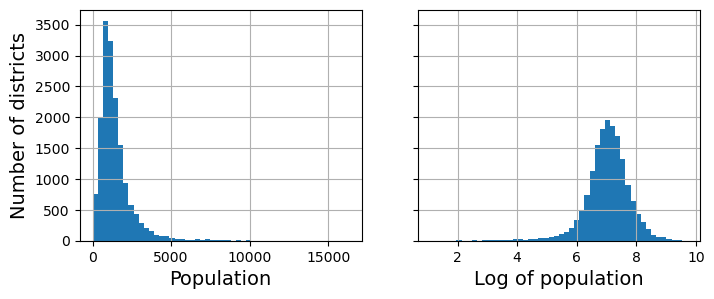

In [61]:
# 重尾
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()

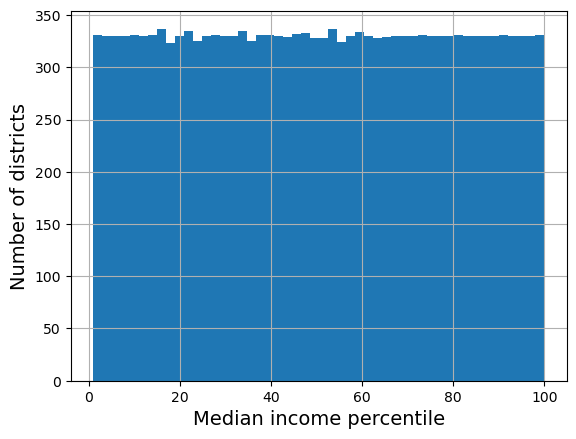

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.8+ MB


In [62]:
# 把数值替换为分位数，会得到均匀分布
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)   # 标签打的1-100， 横坐标是1-100
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
housing.info()

当一个特征具有多峰分布（即具有两个或更多清晰的峰，称为模式）时，例如housing_median_age特征， 可以为每个模式添加一个特征，表示房屋年龄中位数与该特定模式之间的相似性。相似性度量通常使用径向基函数(Radial Basis Function，RBF)计算——任何一个仅取决于输入值和固定点之间距离的函数。最常用的RBF是高斯RBF，其输出值随着输入值远离固定点而呈指数衰减。例如，房屋年龄x和35之间的高斯RBF相似性由方程exp(-γ(x-35)2)给出。超参数γ(gamma)决定了当x远离35时相似性度量衰减的速度。使用Scikit-Learn的rbf_kernel()函数，可以创建一个新的高斯RBF特征来测量房屋年龄中位数与35之间的相似性：

In [63]:
from sklearn.metrics.pairwise import rbf_kernel

# 与房龄35的相似度
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

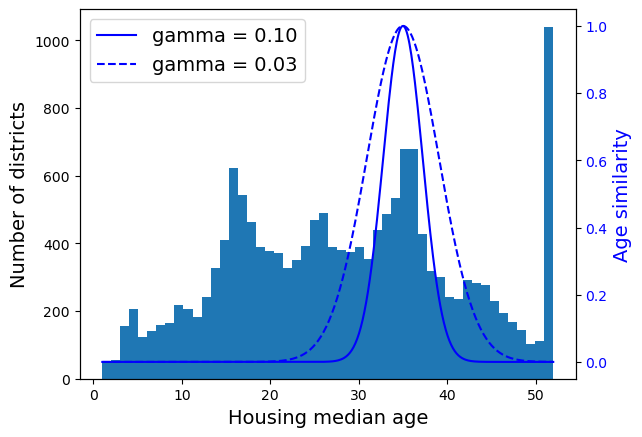

In [64]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)  # 设置刻度的参数
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
plt.show()

如果目标分布有一条重尾，你可以选择用其对数替换目标。但如果这样做，现在回归模型将预测房价中位数的对数，而不是房价中位数本身。如果你想要已预测的房屋中位数，则需要计算模型预测的指数。幸运的是，大多数Scikit-Learn的转换器都有一个inverse_transform()方法，这使得计算它们的逆转换变得容易。

以下代码使用StandardScaler来缩放标签（就像我们对输入所做的那样），然后在生成的缩放标签上训练一个简单的线性回归模型，并使用它对一些新数据进行预测，我们使用经过训练的缩放器的inverse_transform()方法转换回原始尺度。请注意，我们将标签从Pandas Series转换为DataFrame，因为StandardScaler需要2D输入。此外，在此示例中，为简单起见，我们仅在单个原始输入特征（收入中位数）上训练模型：

In [65]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # 假装这是要预测的新数据

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

更方便的方式：使用TransformedTargetRegressor。我们只需要构造它，给它回归模型和标签转换器，然后使用原始的未缩放标签，将它拟合到训练集上。它将自动使用转换器来缩放标签并在缩放后的标签上训练回归模型，就像我们之前所做的那样。然后，当我们想要进行预测时，它会调用回归模型的predict()方法并使用缩放器的inverse_transform()方法来产生预测：

In [66]:
# 更简单的转换标签后的预测方式，直接使用TransformedTargetRegressor
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)  # 预测时自动调用转换器的 inverse_transform
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

尽管Scikit-Learn提供了许多有用的转换器，但需要编写自己的转换器来执行自定义转换、清洗操作或组合一些特定的属性等任务。对于不需要任何训练的转换，只需编写一个函数，将NumPy数组作为输入并输出转换后的数组。例如，如上一节所述，通过将重尾分布的特征替换为它们的对数（假设特征为正且尾部在右侧）来转换具有重尾分布的特征通常是个好主意

In [67]:
# 定制转换器
from sklearn.preprocessing import FunctionTransformer

# FunctionTransformer：自定义转换器 用于不需要训练数据的转换器
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)  # inverse_func 指定反函数
log_pop = log_transformer.transform(housing[["population"]])

rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))  # 不指定反函数，通过kw_args传字典，指定转换函数的超参数
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])
age_simil_35

# rbf_kernel不单独处理特征，向它传递具有2个特征的数组，它会计算2D距离来测量相似性
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])
sf_simil

# 特征组合转换: 计算输入特征0和1之间比率的FunctionTransformer
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [68]:
# 自定义转换器也可以训练：fit, transform, fit_transform
#   get_params(), set_params()  自动超参数调整

# 将TransformerMixin添加为基类即可以得到fit_transform()：默认实现将只调用fit()，然后调用transform()。如果将BaseEstimator添加为基类（避免在构造函数中使用*args和**kwargs），你还将获得两个额外的方法：get_params()和set_params()。这些对于自动超参数调整很有用。
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # 没有 *args, **kwargs, sklearn的规范
        self.with_mean = with_mean

    def fit(self, X, y=None):  # 即使不用y，也需要它
        X = check_array(X)  # 检查X是不是数组
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # 所有估计器会把输入特征的数量存下来
        return self  # 永远返回 self!

    def transform(self, X):
        check_is_fitted(self)  # 检查是否适配过数据 （检查是否有那些下划线结尾的参数)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_


- Scikit-Learn流水线要求fit()方法有两个参数X和y，这就是为什么需要y=None参数，即使不使用y。
- 所有Scikit-Learn估计器都在fit()方法中设置n_features_in_，它们确保传递给transform()或predict()的数据具有这个数量的特征。
- fit()方法必须返回self。
- 此实现并没有100%完成：所有估计器在传递DataFrame时都应在fit()方法中设置feature_names_in_。此外，所有的转换器都应该提供一个get_feature_names_out()方法，以及一个inverse_transform()方法，当它们的转换可以被逆转时

In [69]:
# 转换器在实现中使用其他估计器

# kmeans识别集群， rbf_kernel测量每个样本与每个集群中心的相似程度
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        # KMeans估计器相关参数：集群数量，随机种子
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)

        # sample_weight可指定样本的相对权重
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self # 永远返回self

    def transform(self, X):
        # self.kmeans_.cluster_centers_ 集群中心的位置
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [70]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

similarities[:3].round(2)

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

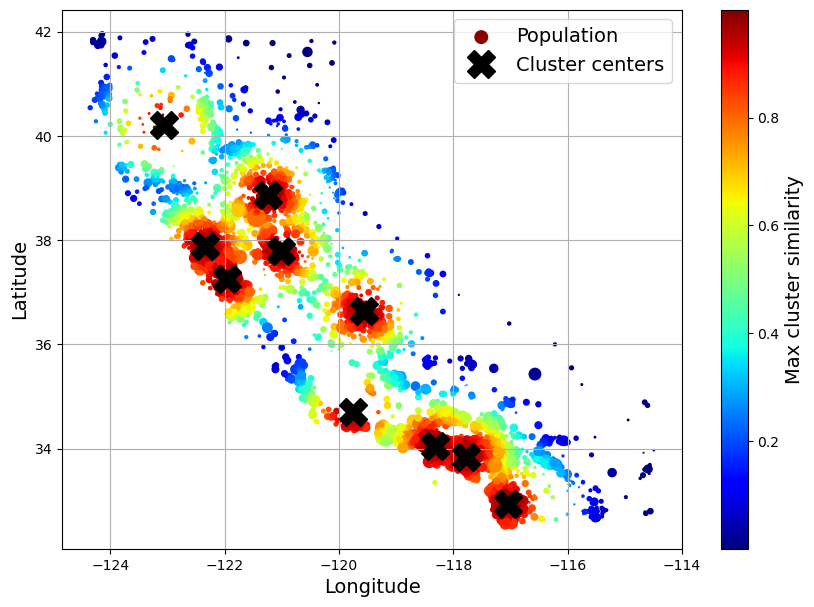

In [71]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
# plt.scatter(cluster_simil.kmeans_.cluster_centers_[:, 1],
#          cluster_simil.kmeans_.cluster_centers_[:, 0],
#          color="black", marker="X", s=200,
#          label="Cluster centers")

plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")

plt.legend(loc="upper right")
plt.show()

todo：转换流水线

In [72]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [73]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())  # 不想给转换器命名，直接make_pieline,把各个转换器按位置参数传递进去


In [74]:
sklearn.set_config(display='diagram') # 所有估计器将呈现交互式图表，可以可视化流水线

num_pipeline


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

todo： 解释调用流水线的fit会发生什么

In [75]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)


df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)  # 恢复成DataFrame
df_housing_num_prepared
df_housing_num_prepared.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942


todo: 流水线读取具体的转换器； 介绍ColumnTransformer

In [76]:
num_pipeline.steps
num_pipeline[1]

num_pipeline[:-1]
num_pipeline.named_steps["simpleimputer"]
num_pipeline.named_steps["simpleimputer"].strategy
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [77]:
from sklearn.compose import ColumnTransformer


num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

# 不同列用不同的转换器流水线
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [78]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [79]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


In [80]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # remainder，剩下的列用什么转换器，现在就剩下housing_median_age

In [81]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

todo: 选择和训练模型

In [82]:

from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000173E1328DF0>)])),
                ('linearregression', LinearRegression())])

In [84]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = 近似值最近的百分位

housing_labels.iloc[:5].values # 对比真实值

array([458300., 483800., 101700.,  96100., 361800.])

In [85]:
# 计算误差百分比
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-47.0%, -22.3%, 26.0%, 4.2%, -9.9%


In [86]:
from sklearn.metrics import mean_squared_error
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse

68652.19447676654

尝试DecisionTreeRegressor，这是一个相当强大的模型，能够在数据中发现复杂的非线性关系

In [87]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000173E1328DF0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [89]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse

0.0

todo: 使用交叉验证进行更好的评估

In [91]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)  # sklearn的交叉验证功能期望越大越好，而不是代价函数（越低越好），因此评分函数实际上与RMSE相反，需要切换符号

In [93]:
tree_rmses
pd.Series(tree_rmses).describe()

count       10.000000
mean     67153.318273
std       1963.580924
min      63925.253106
25%      66083.277180
50%      66795.829871
75%      68074.018403
max      70664.635833
dtype: float64

In [94]:
# 为线性回归模型计算相同的指标
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     69851.585479
std       4077.044404
min      65659.761079
25%      68099.818340
50%      68705.522703
75%      69801.011860
max      80685.254832
dtype: float64

todo：随机森林模型

In [95]:
# 预警： 这段代码可能要跑10分钟

from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [96]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47002.931706
std       1048.451340
min      45667.064036
25%      46494.358345
50%      47093.173938
75%      47274.873814
max      49354.705514
dtype: float64

In [97]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
forest_rmse

17547.52124624957

训练的RMSE是17547，仍然比验证的47000低很多，意味着仍然存在相当多的过拟合
todo：补充文本

todo：微调模型

todo：网格搜索

In [98]:
# 警告： 这段代码要跑 8分钟
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000173E1328DF0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [99]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [100]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x0000017...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000173DF3BF070>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [105]:
# 展示网格搜索过程中  超参数组合的评估结果
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# 下面的代码只是在调整dataframe的显示
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43536,43753,44569,43953
13,15,8,44084,44205,44863,44384
14,15,10,44368,44496,45200,44688
7,10,6,44251,44628,45857,44912
9,10,6,44251,44628,45857,44912


todo：随机搜索

In [106]:
# 警告，这段代码要跑6分钟
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)  # 3折交叉验证，10组超参数探索

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000173DFAFE170>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000173DF8F1C60>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [107]:
# 展示随机搜索过程中，超参数组合的评估结果
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41115,42151,42695,41987
8,32,7,41604,42200,43219,42341
0,41,16,42106,42743,43443,42764
5,42,4,41812,42925,43557,42765
2,23,8,42421,43094,43856,43124
6,24,3,42884,43396,44676,43652
7,26,13,43208,43618,44378,43735
3,21,12,43611,44109,44668,44129
4,13,5,43984,43899,45157,44347
9,4,2,50542,49793,51397,50577


In [108]:
final_model = rnd_search.best_estimator_  # 包括预处理
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.06, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.02,
       0.04, 0.01, 0.  , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.03, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [109]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.1898423270105783, 'log__median_income'),
 (0.07709175866873944, 'cat__ocean_proximity_INLAND'),
 (0.06455488601956336, 'bedrooms__ratio'),
 (0.056936146643377976, 'rooms_per_house__ratio'),
 (0.0490294770805355, 'people_per_house__ratio'),
 (0.03807069074492323, 'geo__Cluster 3 similarity'),
 (0.025643913400094472, 'geo__Cluster 22 similarity'),
 (0.02179127543243723, 'geo__Cluster 17 similarity'),
 (0.021575251507503695, 'geo__Cluster 6 similarity'),
 (0.017868654556924362, 'geo__Cluster 2 similarity'),
 (0.017431400050755975, 'geo__Cluster 32 similarity'),
 (0.015981159400591683, 'geo__Cluster 18 similarity'),
 (0.014888464257396877, 'geo__Cluster 40 similarity'),
 (0.014488389218107146, 'geo__Cluster 43 similarity'),
 (0.014252940099964142, 'geo__Cluster 7 similarity'),
 (0.014038173319370725, 'geo__Cluster 21 similarity'),
 (0.013846025114732161, 'geo__Cluster 38 similarity'),
 (0.013625709964722737, 'geo__Cluster 34 similarity'),
 (0.013547297167034428, 'geo__Cluster 41 simila

todo：sklearn.feature.SelectFromModel

todo: 在测试集上评估系统

In [110]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

41549.20158097943


In [111]:
# 计算泛化误差的95%置信区间
from scipy import stats
confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([39395.35475927, 43596.76969025])

todo：启动，监控和维护系统

In [112]:
import joblib
joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

一旦你的模型转移到生产环境，你就可以加载并使用它。为此，你必须首先导入模型依赖的任何自定义类和函数（这意味着将代码转移到生产环境），然后使用joblib加载模型并使用它进行预测

In [113]:
import joblib

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

todo：web部署/云端部署